# Artifact EDA

In [46]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns

from functools import reduce
from PIL import Image, ImageDraw

In [3]:
sns.set_style('darkgrid')

## Setup

In [4]:
root = '.'

label_file = f'{root}/proj_labels.csv'
image_dir = f'{root}/map-proj-v3_2'
temp_dir = f'{root}/tmp'

## Load Data

In [5]:
df = pd.read_csv(label_file)

## Sample Artifact

In [6]:
def load_img(img):
    return Image.open(img).convert('L')

In [4]:
art_file = os.path.join(image_dir, 'TRA_000828_1805_RED-0104-brt.jpg')

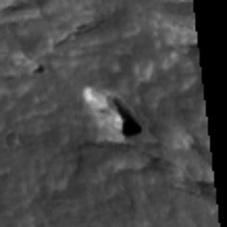

In [35]:
art_image = load_img(art_file)
art_image

## Artifact Detection

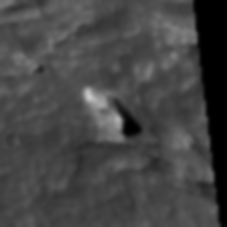

In [11]:
blurred = cv2.GaussianBlur(np.array(art_image), (9, 9), 0)
Image.fromarray(blurred)

In [84]:
_, mask = cv2.threshold(blurred, 1, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

Idenitified artifacts are indeed close to if not 0 exactly

In [85]:
mask

array([[  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       ...,
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255]], dtype=uint8)

Find the components based on the mask

In [113]:
analysis = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S) 
(totalLabels, label_ids, values, centroid) = analysis 

This has picked up a small black like shape mid image

In [114]:
values

array([[    0,     0,   220,   227, 46436],
       [  193,     0,    34,   227,  4722],
       [  118,   104,    24,    33,   371]], dtype=int32)

Resolve this by making two assumptions:

- 1 The real image component will always have the largest area
- 2 The artifacts will always have an area > 2000

In [7]:
def filter_areas(values: np.array, threshold: int=2000) -> np.array:
    filter_idx = values[:, cv2.CC_STAT_AREA] > threshold
    return values[filter_idx]

def order_areas(values: np.array) -> np.array:
    areas = values[:, cv2.CC_STAT_AREA]
    sorted_idx = np.argsort(areas)[::-1] # reverse the sort
    return values[sorted_idx]

def get_bboxes(values) -> np.array:
    return values[:, :-1]

In [118]:
values = filter_areas(values)
values = order_areas(values)

In [119]:
values

array([[    0,     0,   220,   227, 46436],
       [  193,     0,    34,   227,  4722]], dtype=int32)

In [122]:
bboxs = get_bboxes(values)

Now we need to remove the intersection between the bounding boxes

In [8]:
def remove_intersection(bbox1, bbox2, margin: int=5) -> list[int]:
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2

    xA = max(x1, x2)
    yA = max(y1, y2)
    xB = min(x1 + w1, x2 + w2)
    yB = min(y1 + h1, y2 + h2)

    inter_width = max(0, xB - xA)
    inter_height = max(0, yB - yA)

    if inter_height == 0 or inter_width == 0:
        return bbox1

    if x1 < xA:
        return (x1, y1, xA - x1 - margin, h1)
    if x1 + w1 > xB:
        return (xB + margin, y1, x1 + w1 - xB - margin, h1)
    if y1 < yA:
        return (x1, y1, w1, yA - y1 - margin)

    return (x1, yB + margin, w1, y1 + h1 - yB - margin)


In [124]:
x, y, w, h = reduce(remove_intersection, bboxs)
print(x, y, w, h)

0 0 193 227


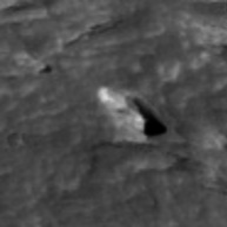

In [125]:
art_crop = art_image.crop((x, y, x+w, y+h))
art_crop = art_crop.resize((art_image.height, art_image.width))
art_crop

## Test Multiple Orientations

In [9]:
def get_mask(img: Image.Image, inv: bool=True):
    blurred = cv2.GaussianBlur(np.array(img), (9, 9), 0)
    mask_flags = cv2.THRESH_BINARY_INV if inv else cv2.THRESH_BINARY
    _, mask = cv2.threshold(blurred, 1, 255, mask_flags)
    return mask

def remove_artifact(img: Image.Image, threshold: int=2000):
    mask = get_mask(img)
    values = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)[2]

    values = filter_areas(values, threshold)
    values = order_areas(values)
    bboxs = get_bboxes(values)

    x, y, w, h = reduce(remove_intersection, bboxs)

    img_crop = img.crop((x, y, x+w, y+h))
    img_crop = img_crop.resize((img.height, img.width))
    return img_crop

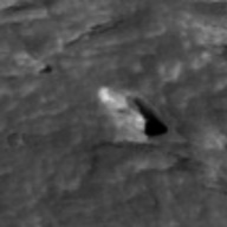

In [252]:
remove_artifact(art_image)

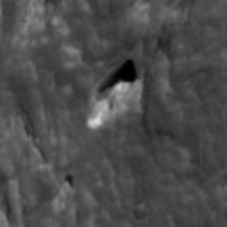

In [253]:
remove_artifact(art_image.rotate(90))

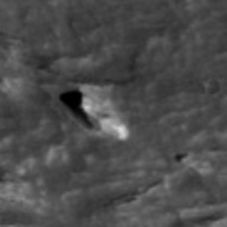

In [254]:
remove_artifact(art_image.rotate(180))

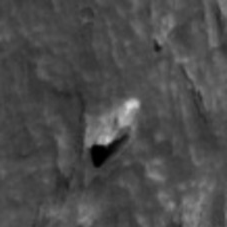

In [255]:
remove_artifact(art_image.rotate(270))

The above has an **issue** its fine when tackling images with the artifacts being a steep top down line, optimizations could be made to handle left to right lines but the bigger issue is around many artifacts being diagonal in which case cropping to one end loses more information than potentially looking for biggest rotation area

## Diagonal Artifact

In [135]:
art_file = os.path.join(image_dir, 'ESP_011341_0980_RED-0005.jpg')

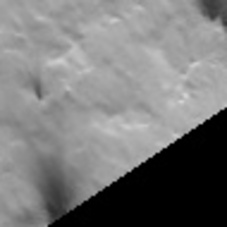

In [136]:
art_image = load_img(art_file)
art_image

Cropping this image all the way to the left vertically or midway horizontally may not be the best approach here, we should consider an optimal area solution that attempts to create the maximum rectangle possible, this would solve far more edge cases (leaving mainly those where a rotation followed by maximum rectangle would be best)

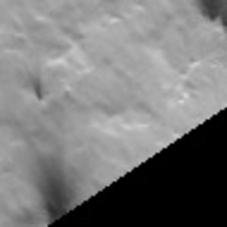

In [147]:
art_image_rgba = art_image.convert('RGBA')
art_image_rgba

In [173]:
def artifact_as_transparent(img: Image.Image, threshold: int=5):
    width, height = img.size
    ImageDraw.floodfill(img, (0, 0), (255, 255, 255, 0), thresh=threshold)
    ImageDraw.floodfill(img, (width-1, 0), (255, 255, 255, 0), thresh=threshold)
    ImageDraw.floodfill(img, (0, height-1), (255, 255, 255, 0), thresh=threshold)
    ImageDraw.floodfill(img, (width-1, height-1), (255, 255, 255, 0), thresh=threshold)

def largest_rect(image):
    width, height = image.size
    data = np.array(image)

    mask = np.where(data[:, :, 3] > 0, 1, 0)

    height_dp = np.zeros((height, width), dtype=int)
    left_dp = np.zeros((height, width), dtype=int)
    right_dp = np.full((height, width), width, dtype=int)

    max_area = 0
    max_rect = [0, 0, 0, 0]

    for y in range(height):
        left = 0
        right = width

        for x in range(width):
            if mask[y, x] == 1:
                height_dp[y, x] = height_dp[y-1, x] + 1 if y > 0 else 1
            else:
                height_dp[y, x] = 0

        for x in range(width):
            if mask[y, x] == 1:
                left_dp[y, x] = max(left_dp[y-1, x], left) if y > 0 else left
            else:
                left_dp[y, x] = 0
                left = x + 1
        
        for x in range(width-1, -1, -1):
            if mask[y, x] == 1:
                right_dp[y, x] = min(right_dp[y-1, x], right) if y > 0 else right
            else:
                right_dp[y, x] = width
                right = x
        
        for x in range(width):
            area = (right_dp[y, x] - left_dp[y, x]) * height_dp[y, x]
            if area > max_area:
                max_area = area
                max_rect = (left_dp[y, x], y - height_dp[y, x] + 1, right_dp[y, x], y + 1)
    
    return np.array(max_rect), max_area

def largest_rotated_rect(image, step: int=10):
    max_area = 0
    max_rect = [0, 0, 0, 0]
    max_angle = 0

    for angle in range(0, 180, step):
        rotated = image.rotate(angle)
        rect, area = largest_rect(rotated)
        if area > max_area:
            max_area = area
            max_rect = rect
            max_angle = angle

    return max_rect, max_angle

In [152]:
artifact_as_transparent(art_image_rgba)

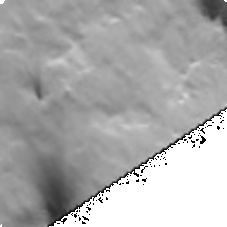

In [153]:
art_image_rgba

In [154]:
bbox = largest_rect(art_image_rgba)[0]

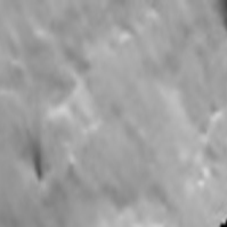

In [155]:
art_image_rgba.crop(bbox).resize(art_image_rgba.size)

This solves most scenarios but we can also brute force it further for situations where a rotation may help considering the smaller base of potential candidate images

In [163]:
art_file = os.path.join(image_dir, 'PSP_002804_0930_RED-0051.jpg')

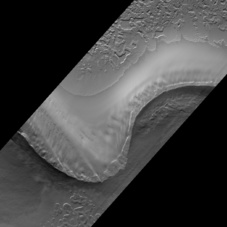

In [168]:
art_image = load_img(art_file)
art_image_rgba = art_image.convert('RGBA')
art_image_rgba

In [169]:
artifact_as_transparent(art_image_rgba)

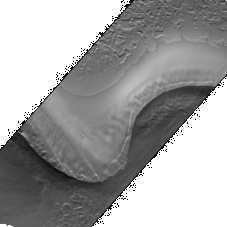

In [170]:
art_image_rgba

In [174]:
bbox, angle = largest_rotated_rect(art_image_rgba)
bbox, angle

(array([ 56,  13, 169, 216]), 40)

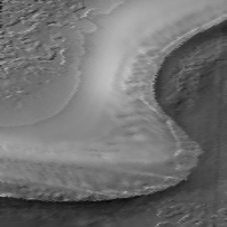

In [176]:
art_image_rgba.rotate(angle).crop(bbox).resize(art_image.size)

## Estimate Number of Artifact Images

In [122]:
def has_artifact(img: str) -> bool:
    img = os.path.join(image_dir, img)
    img = load_img(img)
    mask = get_mask(img)
    values = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)[2]
    values = filter_areas(values)
    return len(values) > 1

In [123]:
df['artifact'] = df['image'].apply(has_artifact)


Text(0.5, 1.0, 'Artifact Distribution')

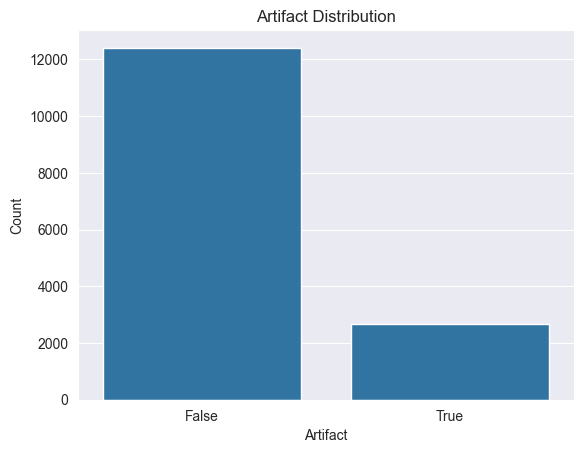

In [124]:
ax = sns.countplot(data=df, x='artifact')
ax.set_ylabel('Count')
ax.set_xlabel('Artifact')
ax.set_title('Artifact Distribution')

Since each photo is augmented ~6 times (not counting test images) then each photo is represented ~7 times so we adjust the estimate accordingly for uniqueness

In [125]:
def get_baseimg(img: str) -> str:
    img = os.path.splitext(img)[0]
    parts = img.split('-')
    return f'{parts[0]}-{parts[1]}.jpg'

In [126]:
df['base'] = df['image'].apply(get_baseimg)

In [127]:
base_df = (df[['base', 'artifact']]
           .groupby('base')
           .max('artifact')
           .reset_index())

Text(0.5, 1.0, 'Base Artifact Distribution')

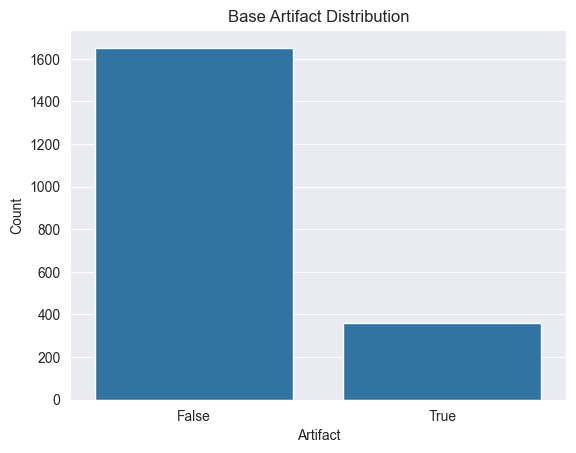

In [128]:

ax = sns.countplot(data=base_df, x='artifact')
ax.set_ylabel('Count')
ax.set_xlabel('Artifact')
ax.set_title('Base Artifact Distribution')

Seeing as theres much fewer baseline images ~390, we can perform the correction on these and do a side by side manual verification before safely applying to all artifacts

In [129]:
base_df.head()

,base,artifact
0,ESP_011289_1950_RED-0009.jpg,True
1,ESP_011289_1950_RED-0044.jpg,False
2,ESP_011289_1950_RED-0066.jpg,False
3,ESP_011289_1950_RED-0092.jpg,False
4,ESP_011289_1950_RED-0102.jpg,False


Create side by sides of the baselines for review

In [187]:
for img_file in base_df[base_df['artifact'] == True]['base']:
    img_path = os.path.join(image_dir, img_file)
    img = load_img(img_path)

    img_copy = img.copy().convert('RGBA')
    artifact_as_transparent(img_copy)
    bbox, angle = largest_rotated_rect(img_copy)
    clean_img = img_copy.rotate(angle).crop(bbox).resize(img.size).convert('L')

    #clean_img = remove_artifact(img, threshold=1500)

    conjoin = Image.new('L', (img.width * 2, img.height))
    conjoin.paste(im=img, box=(0, 0))
    conjoin.paste(im=clean_img, box=(img.width, 0))
    conjoin.save(os.path.join(temp_dir, img_file))

Apply the logic to get the optimal boxes and store for later automation

In [191]:
def get_rect_and_angle(row):
    if not row['artifact']:
        return pd.Series([np.array([0, 0, 227, 227]), 0])

    img_path = os.path.join(image_dir, row['base'])
    img = load_img(img_path).convert('RGBA')

    artifact_as_transparent(img)
    rect, angle = largest_rotated_rect(img)
    return pd.Series([rect, angle])

In [192]:
base_df[['rect', 'angle']] = base_df.apply(get_rect_and_angle, axis=1)

In [223]:
base_df.to_csv('base_proj_labels.csv', index=False)